In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv("data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [4]:
for col in data.columns:
    print(col + ": " + str(data[col].nunique()))

Artist Name: 9149
Track Name: 15129
Popularity: 100
danceability: 909
energy: 1208
key: 11
loudness: 9002
mode: 2
speechiness: 1194
acousticness: 3930
instrumentalness: 4253
liveness: 1459
valence: 1320
tempo: 13562
duration_in min/ms: 14121
time_signature: 4
Class: 11


Можем сказать, что категориальные переменные - это key, mode, time_signature, Class. Перекодируем 

In [5]:
data["key"] = data["key"].astype('category')
data["mode"] = data["mode"].astype('category')
data["time_signature"] = data["time_signature"].astype('category')
data["Class"] = data["Class"].astype('category')


Посмотрим на пропущенные значения.

In [6]:
data.isnull().sum()

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

Много пропущенных значений. Удалять их плохо. Заменим NA на медиану в количественных признаках и на самое часто встречающееся значение в категориальных

In [7]:
# Заполнение в количественных признаках
data['Popularity'] = data['Popularity'].fillna(data['Popularity'].median())
data['instrumentalness'] = data['instrumentalness'].fillna(data['instrumentalness'].median())

# Заполнение в категориальном признаке
mode = data['key'].mode()
data['key'] = data['key'].fillna(mode[0])

In [8]:
data.isnull().sum()

Artist Name           0
Track Name            0
Popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
Class                 0
dtype: int64

Посмотрим, как распределены признаки. Начнем с **категориальных переменных**

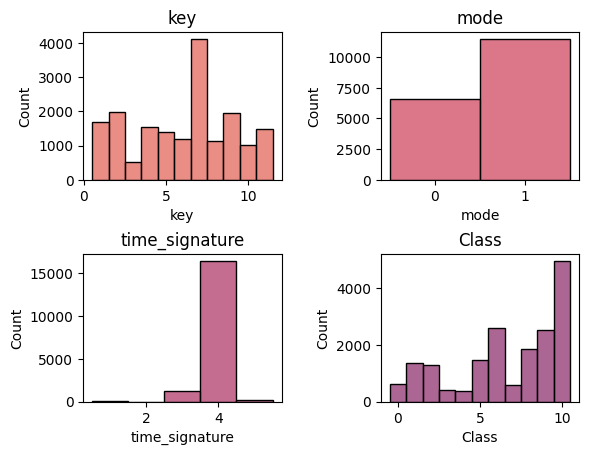

In [9]:
number=1
palette = sns.color_palette("flare")
for i in ['key', 'mode', 'time_signature', 'Class']:
    plt.subplot(2, 2, number)
    sns.histplot(data[i], color = palette[number])
    plt.title(i)
    number += 1
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Есть перекос в сторону 10 жанра и в сторону 4 у тактовых размеров. Данные не очень сбалансированы

Что с числовыми признаками:

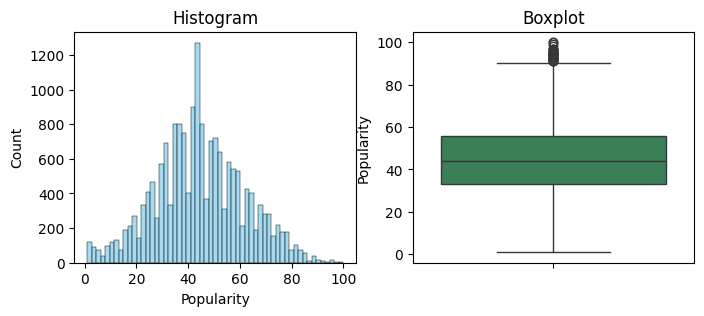

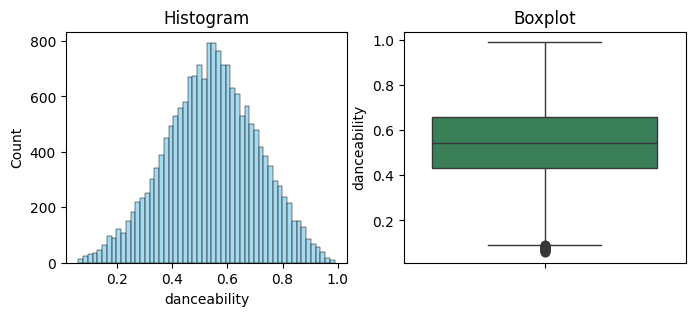

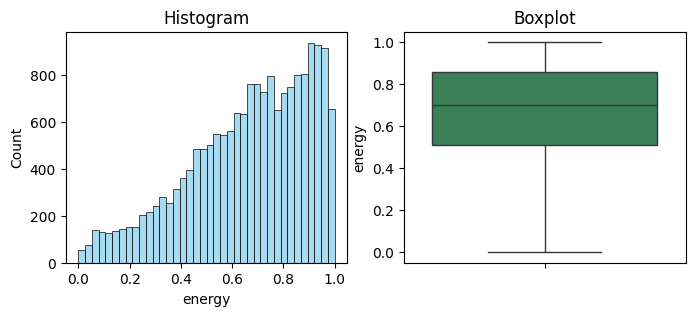

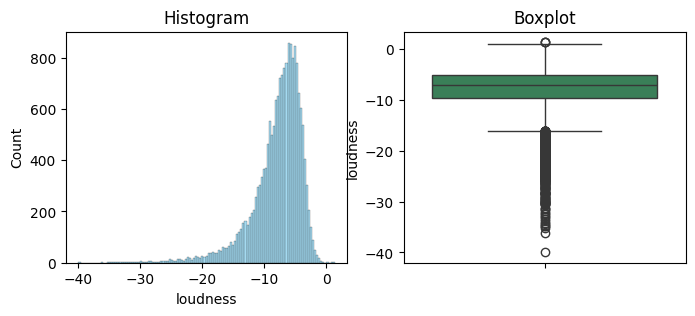

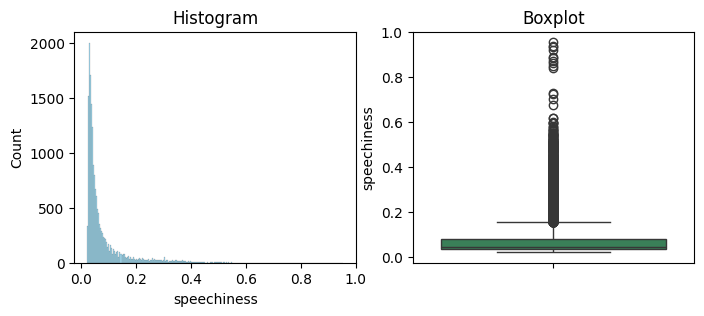

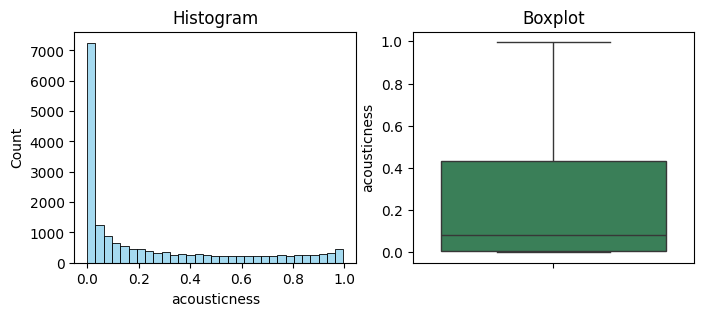

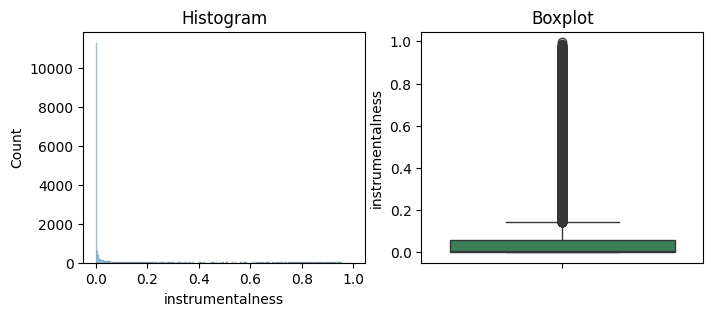

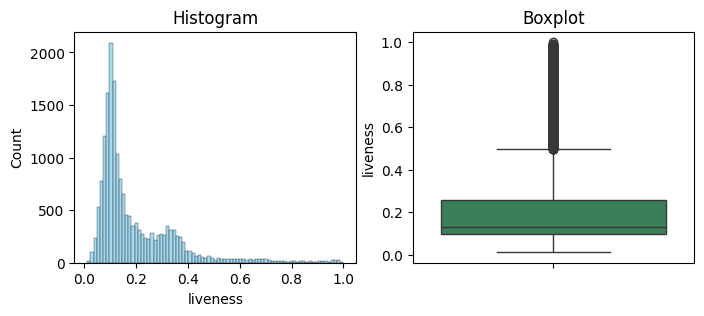

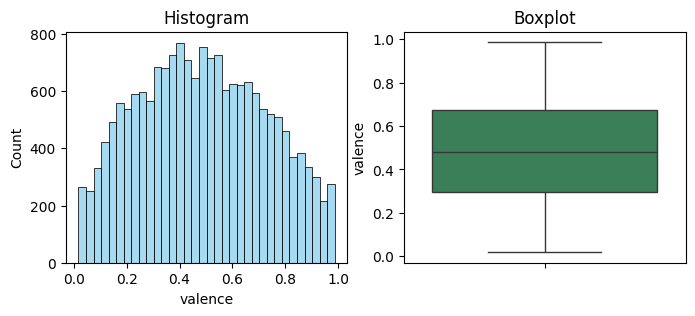

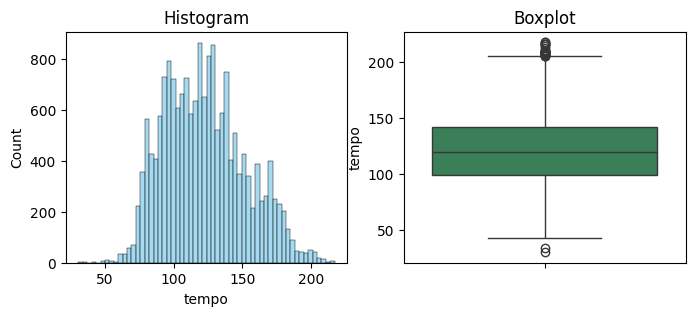

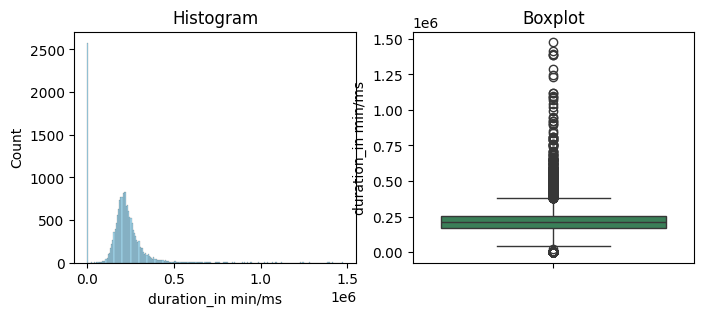

In [10]:
float_columns = data.select_dtypes(include='float64').columns

for i, column in enumerate(float_columns):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    sns.histplot(data[column], ax=ax1, color = 'skyblue')
    ax1.set_title('Histogram')
    sns.boxplot(data[column], ax=ax2, color = 'seagreen')
    ax2.set_title('Boxplot')
    plt.show()

Большинство данных не имеют нормального распределения. Что-то не то с длительностью песен

In [11]:
data['duration_in min/ms'][data['duration_in min/ms'] < 5000]

7        3.105783
10       4.330450
13       4.440250
25       4.015633
34       3.503783
           ...   
17952    5.407783
17959    3.686017
17974    3.408667
17986    4.392883
17988    3.787783
Name: duration_in min/ms, Length: 2580, dtype: float64

Eсть песни в минутах. Нужно все привести к мс

In [12]:
data['duration_in_ms'] = data['duration_in min/ms']
data['duration_in_ms'] = data['duration_in_ms'].apply(lambda x: x*60000 if x < 5000 else x)

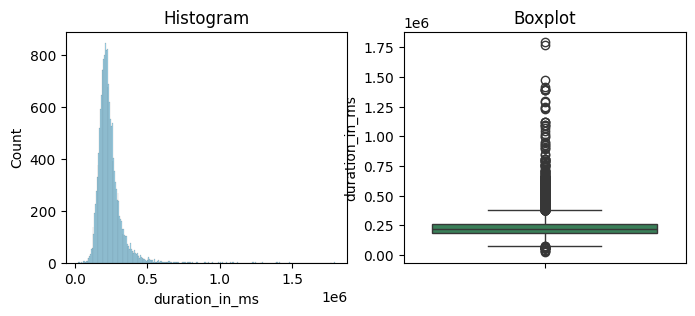

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
sns.histplot(data['duration_in_ms'], ax=ax1, color = 'skyblue')
ax1.set_title('Histogram')
sns.boxplot(data['duration_in_ms'], ax=ax2, color = 'seagreen')
ax2.set_title('Boxplot')
plt.show()

Стало получше, но есть какие-то очень длинные аудиозаписи. Будем иметь это ввиду. Удаляем исходную колонку

In [15]:
data = data.drop(columns=['duration_in min/ms'])

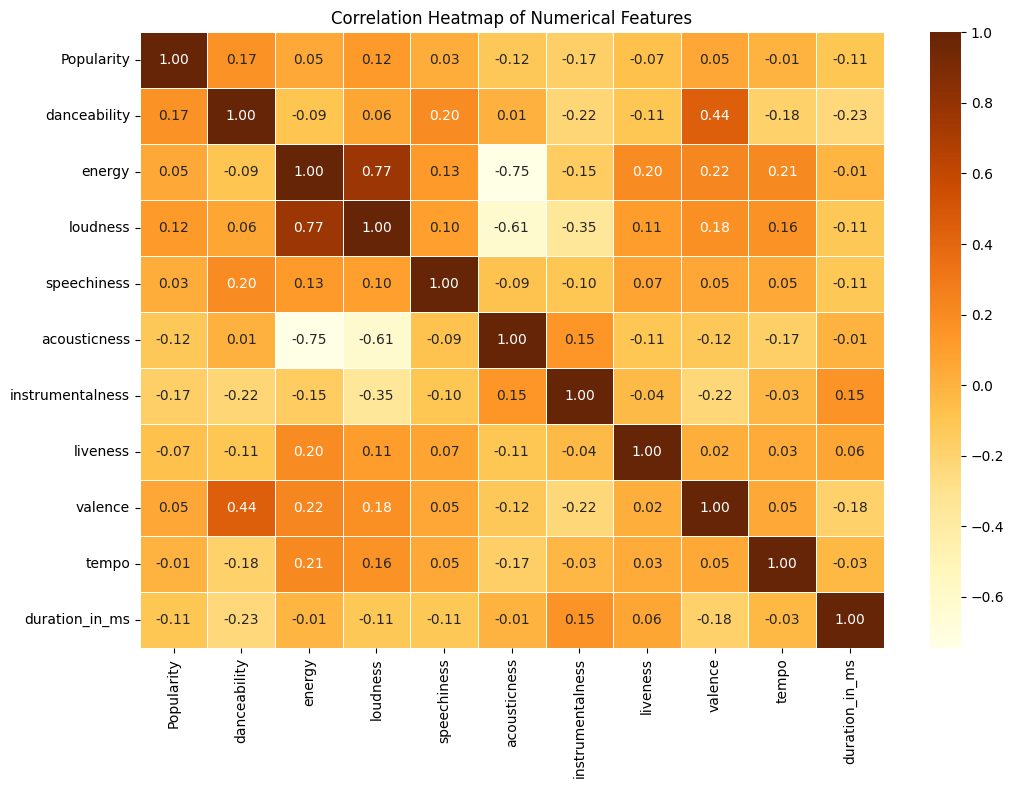

In [19]:
float_columns = data.select_dtypes(include='float64').columns

plt.figure(figsize=(12, 8))
sns.heatmap(data[float_columns].corr(), annot=True, cmap='YlOrBr', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show;

Есть положительная корреляция между **громкостью музыки и энергичностью** и обратная корреляция между **акустическим звучанием и энергичностью** (логично). 

Еще положительную корреляцию имеет танцевальность музыки и позитивность, передаваемая треком (тоже логично).

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [20]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

Определяем X и y

 *Artist Name* и *Track Name*  убираем из анализа

In [21]:
X = data.drop(columns=['Class', 'Artist Name', 'Track Name'])
y = data['Class']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [121]:
numerical_features = ['Popularity', 
      'danceability', 
      'energy', 
      'loudness', 
      'speechiness', 
      'acousticness', 
      'instrumentalness', 
      'liveness', 
      'valence', 
      'tempo', 
      'duration_in_ms']
categorical_features = ['key', 'mode', 'time_signature']

In [156]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

processed_X_train = preprocessor.fit_transform(X_train)

In [157]:
clf = DecisionTreeClassifier()

parameters = {'max_depth': range(1, 15), 
              'min_samples_leaf': range(1, 5), 
              'max_leaf_nodes': range(2, 20),
              'criterion': ['gini', 'entropy']}

In [158]:
grid_search_clf = GridSearchCV(clf, parameters, cv=5)

In [159]:
grid_search_clf.fit(processed_X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 15),
                         'max_leaf_nodes': range(2, 20),
                         'min_samples_leaf': range(1, 5)})

In [160]:
# Проверили, какие гиперпараметры оказались наиболее удачными
grid_search_clf.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_leaf_nodes': 19,
 'min_samples_leaf': 1}

In [161]:
# Отбираем эту модель
best_clf = grid_search_clf.best_estimator_ 

In [162]:
processed_X_test = preprocessor.transform(X_test)

pred_train = best_clf.predict(processed_X_train)
pred_test = best_clf.predict(processed_X_test)

In [163]:
accuracy = accuracy_score(y_train, pred_train)
precision = precision_score(y_train, pred_train, average='macro', zero_division=0)
recall = recall_score(y_train, pred_train, average='macro')
f1 = f1_score(y_train, pred_train, average='macro', zero_division=0)

print(f'Accuracy is {accuracy}')
print(f'Precision is {precision}')
print(f'Recall is {recall}')
print(f'F1-score is {f1}')

Accuracy is 0.43128102541305474
Precision is 0.30317724891484055
Recall is 0.3217772952494892
F1-score is 0.3044409215342357


In [164]:
accuracy = accuracy_score(y_test, pred_test)
precision = precision_score(y_test, pred_test, average='macro', zero_division=0)
recall = recall_score(y_test, pred_test, average='macro')
f1 = f1_score(y_test, pred_test, average='macro', zero_division=0)

print(f'Accuracy is {accuracy}')
print(f'Precision is {precision}')
print(f'Recall is {recall}')
print(f'F1-score is {f1}')

Accuracy is 0.42565014447655036
Precision is 0.29701649445757405
Recall is 0.31404968736041905
F1-score is 0.2978614549324657


**Модель получилась не очень хорошей. Алгоритм дерева решений не дает хороших предсказаний для жанра музыки**

In [165]:
best_clf.feature_importances_

array([0.04921395, 0.07857079, 0.14888136, 0.        , 0.22456473,
       0.26600363, 0.13384882, 0.        , 0.08341605, 0.        ,
       0.01550067, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [155]:
preprocessor.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                 ['key', 'mode', 'time_signature']),
                                ('num', StandardScaler(),
                                 ['Popularity', 'danceability', 'energy',
                                  'loudness', 'speechiness', 'acousticness',
                                  'instrumentalness', 'liveness', 'valence',
                                  'tempo', 'duration_in_ms'])])>

In [167]:
importance = best_clf.feature_importances_[:11]

# Создание DataFrame для отображения значимости признаков
feature_importance_df = pd.DataFrame({'Feature': numerical_features, 'Importance': importance})
feature_importance_df

,Feature,Importance
0,Popularity,0.049214
1,danceability,0.078571
2,energy,0.148881
3,loudness,0.000000
4,speechiness,0.224565
5,acousticness,0.266004
6,instrumentalness,0.133849
7,liveness,0.000000
8,valence,0.083416
9,tempo,0.000000


Наиболее важные признаки - это **energy, speechiness, acousticness**

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

Сдлаем предсказание с помощью метода kNN

In [170]:
clf_knn = KNeighborsClassifier()

parameters_knn = {'n_neighbors': range(1, 30)}

In [171]:
grid_search_knn_clf = GridSearchCV(clf_knn, parameters_knn, cv=5)

In [172]:
grid_search_knn_clf.fit(processed_X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30)})

In [174]:
best_clf_knn = grid_search_knn_clf.best_estimator_ 
best_clf_knn

KNeighborsClassifier(n_neighbors=26)

In [175]:
prediction_knn_train = best_clf_knn.predict(processed_X_train)
prediction_knn_test = best_clf_knn.predict(processed_X_test)

In [176]:
accuracy = accuracy_score(y_train, prediction_knn_train)
precision = precision_score(y_train, prediction_knn_train, average='macro', zero_division=0)
recall = recall_score(y_train, prediction_knn_train, average='macro')
f1 = f1_score(y_train, prediction_knn_train, average='macro', zero_division=0)

print(f'Accuracy is {accuracy}')
print(f'Precision is {precision}')
print(f'Recall is {recall}')
print(f'F1-score is {f1}')

Accuracy is 0.4984070534192784
Precision is 0.5063226185710412
Recall is 0.43047603911555915
F1-score is 0.43514312886387646


In [177]:
accuracy = accuracy_score(y_test, prediction_knn_test)
precision = precision_score(y_test, prediction_knn_test, average='macro', zero_division=0)
recall = recall_score(y_test, prediction_knn_test, average='macro')
f1 = f1_score(y_test, prediction_knn_test, average='macro', zero_division=0)

print(f'Accuracy is {accuracy}')
print(f'Precision is {precision}')
print(f'Recall is {recall}')
print(f'F1-score is {f1}')

Accuracy is 0.45410091131362523
Precision is 0.44487419458832184
Recall is 0.39541878840226924
F1-score is 0.3985945159554359


### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Бесподобный мистер Фокс - классная притча от Уэса Андерсона. Полюбила его давно, когда это еще не было мейнстримом!

![Мистер Фокс](https://images.iptv.rt.ru/images/c6tkqsrir4sslltqoh00.jpg)

2. Небо над Берлином - про англелов, которые наблюдают за людьми на земле. Фоном посмотреть не получится, но если поймать дзен - просто супер.

![](https://diletant.media/upload/medialibrary/af5/af5e072c65089c9d66366b824ad7202e.jpg)

3. Тед Лассо - очень добрый (даже слишком сахарный) сериал, который возвращает веру в человечество

![](https://cdn.forbes.ru/forbes-static/new/2022/06/3DC20171-A7C2-4042-9B8B-8F1E152E0EEA-629f36042050a.jpeg)